<a href="https://www.kaggle.com/code/dataranch/supermarket-sales-prediction-xgboost-fastai?scriptVersionId=110143845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Supermarket Data Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

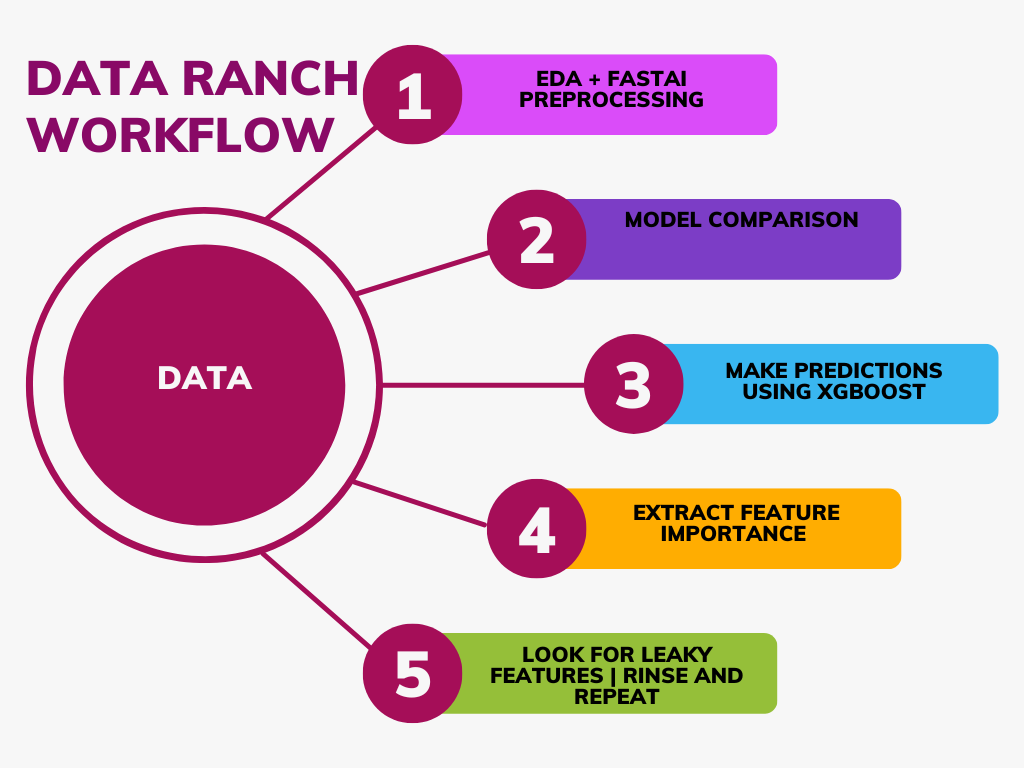

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 567.5 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'superstore'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 4000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/superstore
CSV!


In [12]:
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.58,5,0.45,-383.03
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.37,2,0.20,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Furniture,Chairs,860.93,7,0.00,189.40
3996,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Technology,Phones,769.95,5,0.00,223.29
3997,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Office Supplies,Art,14.98,1,0.00,4.49
3998,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Furniture,Furnishings,373.08,6,0.00,82.08


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.58,5,0.45,-383.03
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.37,2,0.20,2.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Furniture,Chairs,860.93,7,0.00,189.40
3996,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Technology,Phones,769.95,5,0.00,223.29
3997,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Office Supplies,Art,14.98,1,0.00,4.49
3998,Standard Class,Consumer,United States,Kenosha,Wisconsin,53142,Central,Furniture,Furnishings,373.08,6,0.00,82.08


In [15]:
df.isna().sum()

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

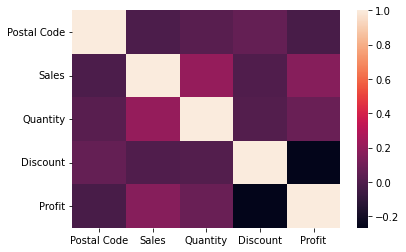

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.58,5,0.45,-383.03
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.37,2,0.20,2.52


In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Postal Code,4000.00,54583.51,31865.74,1040.00,22204.00,55016.00,89031.00,99207.00
Sales,4000.00,230.83,625.50,0.88,16.88,53.95,217.98,22638.48
Quantity,4000.00,3.81,2.25,1.00,2.00,3.00,5.00,14.00
Discount,4000.00,0.16,0.20,0.00,0.00,0.20,0.20,0.80
Profit,4000.00,23.79,189.75,-3839.99,1.80,8.92,29.31,3919.99


In [20]:
df.columns

Index(['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')

Target Variable: Profit
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Sales']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Sales']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'City_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3700030348570966, 'Adjusted R-Squared': 0.35956996409676834, 'RMSE': 160.78512028062224, 'Time taken': 0.06664633750915527}


  5%|▍         | 2/42 [00:00<00:04,  9.31it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.6771404751249311, 'Adjusted R-Squared': 0.6717937568785924, 'RMSE': 115.10214786137895, 'Time taken': 0.14797401428222656}
{'Model': 'BayesianRidge', 'R-Squared': 0.13059200782873737, 'Adjusted R-Squared': 0.1161941684679394, 'RMSE': 188.8810725912589, 'Time taken': 0.04917430877685547}


 10%|▉         | 4/42 [00:00<00:03, 10.86it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7200182047241511, 'Adjusted R-Squared': 0.7153815635285001, 'RMSE': 107.18685372094207, 'Time taken': 0.11126375198364258}
{'Model': 'DummyRegressor', 'R-Squared': -0.0025072125015279667, 'Adjusted R-Squared': -0.019109242772253898, 'RMSE': 202.82448, 'Time taken': 0.015036582946777344}
{'Model': 'ElasticNet', 'R-Squared': 0.10524051849721305, 'Adjusted R-Squared': 0.0904228455551287, 'RMSE': 191.61512233778265, 'Time taken': 0.031187772750854492}


 17%|█▋        | 7/42 [00:00<00:03, 10.89it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.08751190519752283, 'Adjusted R-Squared': 0.07240063738550728, 'RMSE': 193.50412597573785, 'Time taken': 0.2237849235534668}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7530329966276893, 'Adjusted R-Squared': 0.7489430972087847, 'RMSE': 100.6690782840444, 'Time taken': 0.07358384132385254}


 21%|██▏       | 9/42 [00:01<00:08,  3.98it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7691859406940106, 'Adjusted R-Squared': 0.7653635422596439, 'RMSE': 97.32126731584043, 'Time taken': 1.0258066654205322}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:03<00:13,  2.27it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.238981663442522, 'Adjusted R-Squared': -3.309181359779787, 'RMSE': 417.0685049059731, 'Time taken': 1.6364738941192627}


 29%|██▊       | 12/42 [00:03<00:13,  2.28it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8370397312943516, 'Adjusted R-Squared': 0.8343410262075065, 'RMSE': 81.77442371819878, 'Time taken': 0.42238569259643555}


 36%|███▌      | 15/42 [00:04<00:08,  3.23it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.6931643499940914, 'Adjusted R-Squared': 0.6880829952806178, 'RMSE': 112.2094761228054, 'Time taken': 0.5010409355163574}
{'Model': 'HuberRegressor', 'R-Squared': 0.24275954852990522, 'Adjusted R-Squared': 0.23021926079855337, 'RMSE': 176.27613880940444, 'Time taken': 0.047591447830200195}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.4859030711033935, 'Adjusted R-Squared': 0.47738936400064713, 'RMSE': 145.24431, 'Time taken': 0.10761857032775879}


 45%|████▌     | 19/42 [00:05<00:04,  4.67it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.10951038223617371, 'Adjusted R-Squared': 0.0947634204133333, 'RMSE': 191.15737424496305, 'Time taken': 0.6152687072753906}
{'Model': 'Lars', 'R-Squared': 0.13171612211732242, 'Adjusted R-Squared': 0.11733689866194053, 'RMSE': 188.75892476726892, 'Time taken': 0.029284238815307617}
{'Model': 'LarsCV', 'R-Squared': 0.055271397791556987, 'Adjusted R-Squared': 0.03962621074861461, 'RMSE': 196.89294649639788, 'Time taken': 0.05800652503967285}
{'Model': 'Lasso', 'R-Squared': 0.13008176059721788, 'Adjusted R-Squared': 0.1156754712822673, 'RMSE': 188.93649070844165, 'Time taken': 0.02511906623840332}


 55%|█████▍    | 23/42 [00:05<00:02,  6.79it/s]

{'Model': 'LassoCV', 'R-Squared': 0.038511233602543715, 'Adjusted R-Squared': 0.022588489700420267, 'RMSE': 198.63177953277247, 'Time taken': 0.1846003532409668}
{'Model': 'LassoLars', 'R-Squared': -0.0025072411977571374, 'Adjusted R-Squared': -0.01910927194370715, 'RMSE': 202.82448658786453, 'Time taken': 0.053750038146972656}
{'Model': 'LassoLarsCV', 'R-Squared': 0.055271397791556987, 'Adjusted R-Squared': 0.03962621074861461, 'RMSE': 196.89294649639788, 'Time taken': 0.0822904109954834}
{'Model': 'LassoLarsIC', 'R-Squared': 0.12875946230454094, 'Adjusted R-Squared': 0.1143312750560811, 'RMSE': 189.0800303669345, 'Time taken': 0.04135918617248535}


 60%|█████▉    | 25/42 [00:05<00:02,  8.12it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.1317161221173223, 'Adjusted R-Squared': 0.11733689866194041, 'RMSE': 188.75892476726895, 'Time taken': 0.0614321231842041}
{'Model': 'LinearSVR', 'R-Squared': 0.21337524231237048, 'Adjusted R-Squared': 0.20034833549716136, 'RMSE': 179.6637382113733, 'Time taken': 0.06497502326965332}
{'Model': 'MLPRegressor', 'R-Squared': 0.279793562691769, 'Adjusted R-Squared': 0.2678665771057729, 'RMSE': 171.91157753423067, 'Time taken': 5.721588850021362}


 74%|███████▍  | 31/42 [00:12<00:06,  1.74it/s]

{'Model': 'NuSVR', 'R-Squared': 0.031199278663320285, 'Adjusted R-Squared': 0.015155445061566408, 'RMSE': 199.3856291018303, 'Time taken': 0.6117877960205078}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.06574788396124553, 'Adjusted R-Squared': 0.05027619286761009, 'RMSE': 195.79818932627725, 'Time taken': 0.017187118530273438}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.06574788396124553, 'Adjusted R-Squared': 0.05027619286761009, 'RMSE': 195.79818932627725, 'Time taken': 0.04215717315673828}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.22283873686062328, 'Adjusted R-Squared': 0.209968550337296, 'RMSE': 178.57974518188956, 'Time taken': 0.03646683692932129}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [11:39<16:23, 98.39s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.012893668023759464, 'Adjusted R-Squared': -0.02966770329039492, 'RMSE': 203.87245576863543, 'Time taken': 687.3018999099731}


 79%|███████▊  | 33/42 [11:39<12:16, 81.81s/it]

{'Model': 'RANSACRegressor', 'R-Squared': 0.28668543109969447, 'Adjusted R-Squared': 0.2748725783663136, 'RMSE': 171.08706392387572, 'Time taken': 0.31004810333251953}


 83%|████████▎ | 35/42 [11:41<06:27, 55.39s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7483986933906351, 'Adjusted R-Squared': 0.7442320475486965, 'RMSE': 101.60920940957995, 'Time taken': 1.3927195072174072}
{'Model': 'Ridge', 'R-Squared': 0.13170380227083445, 'Adjusted R-Squared': 0.117324374792517, 'RMSE': 188.76026388733484, 'Time taken': 0.021600008010864258}
{'Model': 'RidgeCV', 'R-Squared': 0.131592219660714, 'Adjusted R-Squared': 0.11721094431751566, 'RMSE': 188.7723920564792, 'Time taken': 0.03578376770019531}
{'Model': 'SGDRegressor', 'R-Squared': 0.1318483638132737, 'Adjusted R-Squared': 0.11747133034776103, 'RMSE': 188.7445500037378, 'Time taken': 0.038758277893066406}


 90%|█████████ | 38/42 [11:42<02:11, 32.76s/it]

{'Model': 'SVR', 'R-Squared': 0.025931531932619878, 'Adjusted R-Squared': 0.009800461760803403, 'RMSE': 199.92696288752106, 'Time taken': 0.9095730781555176}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.1317161221173223, 'Adjusted R-Squared': 0.11733689866194041, 'RMSE': 188.75892476726895, 'Time taken': 0.018965482711791992}
{'Model': 'TweedieRegressor', 'R-Squared': 0.08725267005665605, 'Adjusted R-Squared': 0.07213710917861338, 'RMSE': 193.5316109957358, 'Time taken': 0.0335543155670166}


 98%|█████████▊| 41/42 [11:43<00:20, 20.74s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.777473540676453, 'Adjusted R-Squared': 0.7737883891207764, 'RMSE': 95.55809, 'Time taken': 0.7905983924865723}


100%|██████████| 42/42 [11:43<00:00, 16.75s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7000402699168891, 'Adjusted R-Squared': 0.6950727839409905, 'RMSE': 110.94509420357406, 'Time taken': 0.2988555431365967}
Project: superstore
superstore
Target: Profit
Profit
Target Standard Deviation: 186.40939331054688
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
GradientBoostingRegressor                    0.83       0.84  81.77   
XGBRegressor                                 0.77       0.78  95.56   
ExtraTreesRegressor                          0.77       0.77  97.32   
ExtraTreeRegressor                           0.75       0.75 100.67   
RandomForestRegressor                        0.74       0.75 101.61   
DecisionTreeRegressor                        0.72       0.72 107.19   
LGBMRegressor                                0.70       0.70 110.95   
HistGradientBoostingRegressor                0.69       0.69 112.21   
BaggingRegressor           

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost Predictions vs Actual==========
   actual  predicted
0    1.41       3.22
1    0.48      -0.02
2  121.76     283.38
3   25.88      15.40
4  -18.53     -16.84
XGBoost RMSE:  95.57752


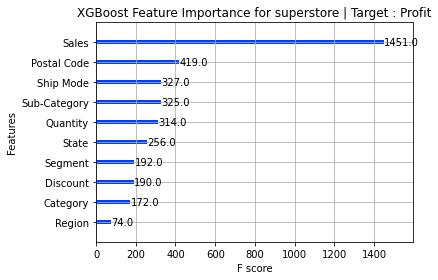

Target Variable: Discount
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Sales', 'Profit']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'City_na']
Tabular Object size: 3997


  7%|▋         | 3/42 [00:00<00:03, 10.92it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7516999810155818, 'Adjusted R-Squared': 0.7475880061788971, 'RMSE': 1.372085977603859, 'Time taken': 0.16458725929260254}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9841648651552151, 'Adjusted R-Squared': 0.9839026272533269, 'RMSE': 0.34650047362561925, 'Time taken': 0.09599542617797852}
{'Model': 'BayesianRidge', 'R-Squared': 0.03628639617616736, 'Adjusted R-Squared': 0.020326807832588, 'RMSE': 2.7031300740646906, 'Time taken': 0.03439974784851074}


 12%|█▏        | 5/42 [00:00<00:02, 13.32it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9722682929852615, 'Adjusted R-Squared': 0.9718090417862913, 'RMSE': 0.45854424926681786, 'Time taken': 0.0779867172241211}
{'Model': 'DummyRegressor', 'R-Squared': -0.001640273191721553, 'Adjusted R-Squared': -0.01822794650572468, 'RMSE': 2.755807251528767, 'Time taken': 0.038727521896362305}
{'Model': 'ElasticNet', 'R-Squared': 0.040396339592643105, 'Adjusted R-Squared': 0.02450481400627924, 'RMSE': 2.6973599044768974, 'Time taken': 0.023863792419433594}


 17%|█▋        | 7/42 [00:00<00:03, 10.32it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.054764601332731755, 'Adjusted R-Squared': 0.03911102148219103, 'RMSE': 2.677089793451918, 'Time taken': 0.22703766822814941}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9301755234093191, 'Adjusted R-Squared': 0.9290191944976263, 'RMSE': 0.7276068751089989, 'Time taken': 0.029850006103515625}


 21%|██▏       | 9/42 [00:01<00:04,  6.72it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9848271577438135, 'Adjusted R-Squared': 0.9845758877446664, 'RMSE': 0.3391770206162892, 'Time taken': 0.43381404876708984}
{'Model': 'GammaRegressor', 'R-Squared': 0.02289213239180432, 'Adjusted R-Squared': 0.006710728214853301, 'RMSE': 2.721850106242858, 'Time taken': 0.028978586196899414}


 26%|██▌       | 11/42 [00:02<00:12,  2.40it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.23924404650862097, 'Adjusted R-Squared': -0.25976655938073834, 'RMSE': 3.0652886009560323, 'Time taken': 1.7976946830749512}


 29%|██▊       | 12/42 [00:03<00:13,  2.28it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9293192373212822, 'Adjusted R-Squared': 0.9281487278756474, 'RMSE': 0.7320547503460094, 'Time taken': 0.5159482955932617}


 36%|███▌      | 15/42 [00:05<00:12,  2.21it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9867148915009623, 'Adjusted R-Squared': 0.9864948833347361, 'RMSE': 0.3173770378109928, 'Time taken': 1.5559844970703125}
{'Model': 'HuberRegressor', 'R-Squared': -0.29235237595272534, 'Adjusted R-Squared': -0.3137543898220061, 'RMSE': 3.1302817007049653, 'Time taken': 0.051050424575805664}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.3754621496659354, 'Adjusted R-Squared': 0.3651194846285559, 'RMSE': 2.176067344168821, 'Time taken': 0.1126556396484375}


 45%|████▌     | 19/42 [00:05<00:06,  3.64it/s]

{'Model': 'KernelRidge', 'R-Squared': -1.2771039907828352, 'Adjusted R-Squared': -1.3148139931779648, 'RMSE': 4.155127759870189, 'Time taken': 0.6330349445343018}
{'Model': 'Lars', 'R-Squared': 0.030282905542704075, 'Adjusted R-Squared': 0.014223896335130992, 'RMSE': 2.711536628076112, 'Time taken': 0.03319597244262695}
{'Model': 'LarsCV', 'R-Squared': 0.05050586820265113, 'Adjusted R-Squared': 0.0347817615614211, 'RMSE': 2.6831137945213777, 'Time taken': 0.06408882141113281}
{'Model': 'Lasso', 'R-Squared': -0.001640273191721553, 'Adjusted R-Squared': -0.01822794650572468, 'RMSE': 2.755807251528767, 'Time taken': 0.025337934494018555}


 55%|█████▍    | 23/42 [00:06<00:03,  5.70it/s]

{'Model': 'LassoCV', 'R-Squared': 0.04908701787197545, 'Adjusted R-Squared': 0.0333394143462884, 'RMSE': 2.6851177646519053, 'Time taken': 0.1914234161376953}
{'Model': 'LassoLars', 'R-Squared': -0.001640273191721553, 'Adjusted R-Squared': -0.01822794650572468, 'RMSE': 2.755807251528767, 'Time taken': 0.025438785552978516}
{'Model': 'LassoLarsCV', 'R-Squared': 0.05050586820265113, 'Adjusted R-Squared': 0.0347817615614211, 'RMSE': 2.6831137945213777, 'Time taken': 0.08307504653930664}
{'Model': 'LassoLarsIC', 'R-Squared': 0.04590734673573138, 'Adjusted R-Squared': 0.030107086235813596, 'RMSE': 2.6896032782248667, 'Time taken': 0.0507199764251709}


 60%|█████▉    | 25/42 [00:06<00:02,  6.64it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.030282905542704408, 'Adjusted R-Squared': 0.014223896335131325, 'RMSE': 2.7115366280761117, 'Time taken': 0.06690001487731934}
{'Model': 'LinearSVR', 'R-Squared': -0.5332169148878225, 'Adjusted R-Squared': -0.5586077682553916, 'RMSE': 3.4095318404279253, 'Time taken': 0.1143031120300293}
{'Model': 'MLPRegressor', 'R-Squared': 0.564342254004625, 'Adjusted R-Squared': 0.5571275397397335, 'RMSE': 1.817463382722609, 'Time taken': 6.585514068603516}


 71%|███████▏  | 30/42 [00:13<00:09,  1.33it/s]

{'Model': 'NuSVR', 'R-Squared': 0.3812887117165562, 'Adjusted R-Squared': 0.37104253751568395, 'RMSE': 2.1658928591537574, 'Time taken': 0.7199711799621582}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0320539177128677, 'Adjusted R-Squared': 0.016024237369259176, 'RMSE': 2.7090594319070616, 'Time taken': 0.02024102210998535}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.02156287695958803, 'Adjusted R-Squared': 0.005359459635351893, 'RMSE': 2.7237008765130333, 'Time taken': 0.049494028091430664}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.1778746365014752, 'Adjusted R-Squared': -1.2139413502269774, 'RMSE': 4.063585370782487, 'Time taken': 0.03496956825256348}
{'Model': 'PoissonRegressor', 'R-Squared': -0.01985225543516722, 'Adjusted R-Squared': -0.03674152845511269, 'RMSE': 2.7807476567841882, 'Time taken': 0.04172968864440918}


 76%|███████▌  | 32/42 [07:55<10:36, 63.67s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.08863457002054731, 'Adjusted R-Squared': -0.10666291321833987, 'RMSE': 2.8729893115946465, 'Time taken': 461.665061712265}


 79%|███████▊  | 33/42 [07:55<07:59, 53.31s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.7828154441893631, 'Adjusted R-Squared': -0.8123397763861295, 'RMSE': 3.676597972867377, 'Time taken': 0.27989935874938965}


 88%|████████▊ | 37/42 [07:56<02:05, 25.10s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9891891736805788, 'Adjusted R-Squared': 0.9890101408880279, 'RMSE': 0.2863006900207944, 'Time taken': 0.8538353443145752}
{'Model': 'Ridge', 'R-Squared': 0.030452670214554445, 'Adjusted R-Squared': 0.014396472396451476, 'RMSE': 2.711299268501333, 'Time taken': 0.019734621047973633}
{'Model': 'RidgeCV', 'R-Squared': 0.031964347731781695, 'Adjusted R-Squared': 0.015933184063645633, 'RMSE': 2.7091847719406106, 'Time taken': 0.05056309700012207}
{'Model': 'SGDRegressor', 'R-Squared': -0.0062678639078666, 'Adjusted R-Squared': -0.02293217248213697, 'RMSE': 2.762165847951321, 'Time taken': 0.09635424613952637}


 90%|█████████ | 38/42 [07:57<01:22, 20.68s/it]

{'Model': 'SVR', 'R-Squared': 0.38866044034447533, 'Adjusted R-Squared': 0.37853634572597616, 'RMSE': 2.1529512670181727, 'Time taken': 0.8502445220947266}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.030282905542704408, 'Adjusted R-Squared': 0.014223896335131325, 'RMSE': 2.7115366280761117, 'Time taken': 0.02400493621826172}
{'Model': 'TweedieRegressor', 'R-Squared': 0.1036090163815293, 'Adjusted R-Squared': 0.08876432493307052, 'RMSE': 2.6070039509517726, 'Time taken': 0.06179523468017578}


100%|██████████| 42/42 [07:58<00:00, 11.40s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9868344979492361, 'Adjusted R-Squared': 0.9866164705267393, 'RMSE': 0.31594515, 'Time taken': 0.8252835273742676}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9876576903959139, 'Adjusted R-Squared': 0.9874532954597952, 'RMSE': 0.3059082346534462, 'Time taken': 0.1886906623840332}
Project: superstore
superstore
Target: Discount
Discount


Target Standard Deviation: 2.953295085975979
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.99       0.99  0.29        0.85
LGBMRegressor                                0.99       0.99  0.31        0.19
XGBRegressor                                 0.99       0.99  0.32        0.83
HistGradientBoostingRegressor                0.99       0.99  0.32        1.56
ExtraTreesRegressor                          0.98       0.98  0.34        0.43
BaggingRegressor                             0.98       0.98  0.35        0.10
DecisionTreeRegressor                        0.97       0.97  0.46        0.08
ExtraTreeRegressor                           0.93       0.93  0.73        0.03
GradientBoostingRegressor                    0.93       0.93  0.73        0.52
AdaBoostRegressor                            0.75       0.75  1.37        0.16
MLPRegr

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       4.00
1       1       1.02
2       1       0.96
3       1       1.39
4       4       4.05
XGBoost RMSE:  0.3159656


<Figure size 432x288 with 0 Axes>

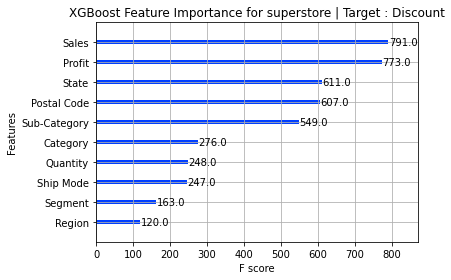

Target Variable: Quantity
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Sales', 'Profit']
13
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'City_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.07041100490081487, 'Adjusted R-Squared': 0.055016537466051285, 'RMSE': 2.2200717471814237, 'Time taken': 0.08099555969238281}


  5%|▍         | 2/42 [00:00<00:04,  8.67it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.1885618767039272, 'Adjusted R-Squared': 0.17512404791048908, 'RMSE': 2.074193300372252, 'Time taken': 0.14931035041809082}
{'Model': 'BayesianRidge', 'R-Squared': 0.03110526491091925, 'Adjusted R-Squared': 0.015059874393520412, 'RMSE': 2.266521385421884, 'Time taken': 0.037857770919799805}


 10%|▉         | 4/42 [00:00<00:02, 12.88it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.31528928500945974, 'Adjusted R-Squared': -0.33707114578031705, 'RMSE': 2.640779647458879, 'Time taken': 0.06284499168395996}
{'Model': 'DummyRegressor', 'R-Squared': -0.002947970526586685, 'Adjusted R-Squared': -0.019557299974797715, 'RMSE': 2.306007551223821, 'Time taken': 0.031101465225219727}
{'Model': 'ElasticNet', 'R-Squared': -0.002947970526586685, 'Adjusted R-Squared': -0.019557299974797715, 'RMSE': 2.306007551223821, 'Time taken': 0.03256535530090332}


 17%|█▋        | 7/42 [00:00<00:02, 13.28it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.029120387872496156, 'Adjusted R-Squared': 0.013042126779938767, 'RMSE': 2.2688417946505046, 'Time taken': 0.15413546562194824}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.4035732391719755, 'Adjusted R-Squared': -0.4268171272092185, 'RMSE': 2.7279666883626015, 'Time taken': 0.03975105285644531}


 21%|██▏       | 9/42 [00:01<00:07,  4.60it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.1807677490554913, 'Adjusted R-Squared': 0.16720084553666503, 'RMSE': 2.0841311446944397, 'Time taken': 0.9287292957305908}
{'Model': 'GammaRegressor', 'R-Squared': 0.02043472101040955, 'Adjusted R-Squared': 0.004212620848798476, 'RMSE': 2.278967934659672, 'Time taken': 0.030498266220092773}


 26%|██▌       | 11/42 [00:03<00:13,  2.31it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -141386.4777913987, 'Adjusted R-Squared': -143727.92646819894, 'RMSE': 865.8187702474734, 'Time taken': 1.7020244598388672}


 29%|██▊       | 12/42 [00:03<00:13,  2.24it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.2209139135557988, 'Adjusted R-Squared': 0.208011850977742, 'RMSE': 2.0324236850361963, 'Time taken': 0.5028724670410156}


 36%|███▌      | 15/42 [00:04<00:08,  3.19it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2273287967725396, 'Adjusted R-Squared': 0.21453296792928234, 'RMSE': 2.0240390471649796, 'Time taken': 0.5069758892059326}
{'Model': 'HuberRegressor', 'R-Squared': -0.01727796600193554, 'Adjusted R-Squared': -0.03412460747712687, 'RMSE': 2.3224230974644153, 'Time taken': 0.045417070388793945}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.09980089977984097, 'Adjusted R-Squared': -0.11801416308829693, 'RMSE': 2.4147854948696357, 'Time taken': 0.10372161865234375}


 45%|████▌     | 19/42 [00:05<00:05,  4.47it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.8447457357362436, 'Adjusted R-Squared': -2.908416684226143, 'RMSE': 4.514974846064297, 'Time taken': 0.673952579498291}
{'Model': 'Lars', 'R-Squared': 0.030986259816835116, 'Adjusted R-Squared': 0.014938898514438748, 'RMSE': 2.266660574592334, 'Time taken': 0.03098011016845703}
{'Model': 'LarsCV', 'R-Squared': 0.02805192363336495, 'Adjusted R-Squared': 0.011955968228567149, 'RMSE': 2.270089894672271, 'Time taken': 0.0630333423614502}
{'Model': 'Lasso', 'R-Squared': -0.002947970526586685, 'Adjusted R-Squared': -0.019557299974797715, 'RMSE': 2.306007551223821, 'Time taken': 0.026662826538085938}


 55%|█████▍    | 23/42 [00:05<00:02,  6.58it/s]

{'Model': 'LassoCV', 'R-Squared': 0.024885927429582955, 'Adjusted R-Squared': 0.00873754151440409, 'RMSE': 2.2737841520690822, 'Time taken': 0.19999027252197266}
{'Model': 'LassoLars', 'R-Squared': -0.002947970526586685, 'Adjusted R-Squared': -0.019557299974797715, 'RMSE': 2.306007551223821, 'Time taken': 0.02615070343017578}
{'Model': 'LassoLarsCV', 'R-Squared': 0.02805192363336495, 'Adjusted R-Squared': 0.011955968228567149, 'RMSE': 2.270089894672271, 'Time taken': 0.08586716651916504}
{'Model': 'LassoLarsIC', 'R-Squared': 0.03136990989368249, 'Adjusted R-Squared': 0.015328902032049174, 'RMSE': 2.266211824199203, 'Time taken': 0.0420382022857666}
{'Model': 'LinearRegression', 'R-Squared': 0.030986259816835116, 'Adjusted R-Squared': 0.014938898514438748, 'RMSE': 2.266660574592334, 'Time taken': 0.02926945686340332}


 60%|█████▉    | 25/42 [00:05<00:02,  7.85it/s]

{'Model': 'LinearSVR', 'R-Squared': -0.04967923061302271, 'Adjusted R-Squared': -0.0670624535403721, 'RMSE': 2.359118874288792, 'Time taken': 0.10599684715270996}
{'Model': 'MLPRegressor', 'R-Squared': 0.06445020495162912, 'Adjusted R-Squared': 0.048957023632356766, 'RMSE': 2.227178251908771, 'Time taken': 5.958641767501831}


 74%|███████▍  | 31/42 [00:12<00:06,  1.66it/s]

{'Model': 'NuSVR', 'R-Squared': 0.06163375181542097, 'Adjusted R-Squared': 0.046093928597077616, 'RMSE': 2.230528169416065, 'Time taken': 0.6758711338043213}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.03664855582953519, 'Adjusted R-Squared': 0.020694965034355528, 'RMSE': 2.2600284151420906, 'Time taken': 0.0173490047454834}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.02996573745103326, 'Adjusted R-Squared': 0.013901475778247852, 'RMSE': 2.2678538337807925, 'Time taken': 0.044220685958862305}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.5495596209911442, 'Adjusted R-Squared': -1.5917816274534178, 'RMSE': 3.6766654101817324, 'Time taken': 0.03512763977050781}
{'Model': 'PoissonRegressor', 'R-Squared': 0.017562336267339274, 'Adjusted R-Squared': 0.0012926679507474503, 'RMSE': 2.2823068040118315, 'Time taken': 0.037369489669799805}


 76%|███████▌  | 32/42 [06:51<09:33, 57.33s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.15571721813092876, 'Adjusted R-Squared': -0.17485648416367017, 'RMSE': 2.4754109910247983, 'Time taken': 398.8887548446655}


 79%|███████▊  | 33/42 [06:51<07:09, 47.68s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.30749137994090425, 'Adjusted R-Squared': -0.3291441034303715, 'RMSE': 2.632939865895556, 'Time taken': 0.26233911514282227}


 83%|████████▎ | 35/42 [06:53<03:46, 32.38s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.23803608658992437, 'Adjusted R-Squared': 0.22541757592198686, 'RMSE': 2.00996606425938, 'Time taken': 1.403886079788208}
{'Model': 'Ridge', 'R-Squared': 0.030987717448702767, 'Adjusted R-Squared': 0.014940380285432875, 'RMSE': 2.2666588697878547, 'Time taken': 0.019910097122192383}
{'Model': 'RidgeCV', 'R-Squared': 0.03100038586972287, 'Adjusted R-Squared': 0.014953258501960276, 'RMSE': 2.266644053111513, 'Time taken': 0.04634809494018555}
{'Model': 'SGDRegressor', 'R-Squared': 0.022645382618148746, 'Adjusted R-Squared': 0.006459892139213608, 'RMSE': 2.276394919534586, 'Time taken': 0.03100872039794922}


 90%|█████████ | 38/42 [06:54<01:16, 19.20s/it]

{'Model': 'SVR', 'R-Squared': 0.0022958648401135706, 'Adjusted R-Squared': -0.01422662402240693, 'RMSE': 2.2999712603553286, 'Time taken': 0.8708541393280029}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.030986259816835116, 'Adjusted R-Squared': 0.014938898514438748, 'RMSE': 2.266660574592334, 'Time taken': 0.022930383682250977}
{'Model': 'TweedieRegressor', 'R-Squared': 0.02334299815875729, 'Adjusted R-Squared': 0.007169060548647521, 'RMSE': 2.2755823526707206, 'Time taken': 0.03496503829956055}


100%|██████████| 42/42 [06:55<00:00,  9.88s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.18962969616237024, 'Adjusted R-Squared': 0.17620955100327573, 'RMSE': 2.072828, 'Time taken': 0.8084938526153564}
{'Model': 'LGBMRegressor', 'R-Squared': 0.2242750386665303, 'Adjusted R-Squared': 0.2114286380329824, 'RMSE': 2.0280348157288426, 'Time taken': 0.18116140365600586}
Project: superstore
superstore
Target: Quantity
Quantity
Target Standard Deviation: 2.242091334034175
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
RandomForestRegressor                        0.23       0.24   2.01   
HistGradientBoostingRegressor                0.21       0.23   2.02   
LGBMRegressor                                0.21       0.22   2.03   
GradientBoostingRegressor                    0.21       0.22   2.03   
XGBRegressor                                 0.18       0.19   2.07   
BaggingRegressor                             0.18       0.19   2.07   
ExtraTrees

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       3.80
1       5       4.34
2       4       3.90
3       3       2.78
4       1       0.99
XGBoost RMSE:  2.0742145


<Figure size 432x288 with 0 Axes>

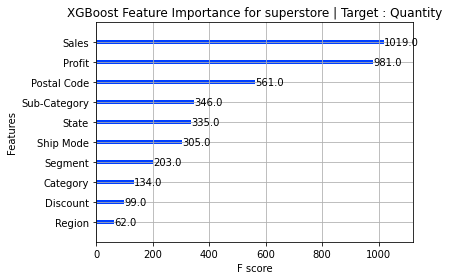

Target Variable: Sales
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Sub-Category', 'Quantity', 'Discount', 'City_na']
Tabular Object size: 3997


  5%|▍         | 2/42 [00:00<00:07,  5.33it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.13766911908613344, 'Adjusted R-Squared': -0.1565094994022096, 'RMSE': 990.1334131243926, 'Time taken': 0.21136474609375}
{'Model': 'BaggingRegressor', 'R-Squared': 0.2718728177680666, 'Adjusted R-Squared': 0.2598146606100855, 'RMSE': 792.1170360894382, 'Time taken': 0.16773176193237305}


 10%|▉         | 4/42 [00:00<00:04,  8.32it/s]

{'Model': 'BayesianRidge', 'R-Squared': -0.1144462285670329, 'Adjusted R-Squared': -0.13290202598279266, 'RMSE': 979.9756643860752, 'Time taken': 0.0379636287689209}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.34327678041688825, 'Adjusted R-Squared': 0.33240110926455646, 'RMSE': 752.2754991480995, 'Time taken': 0.11899423599243164}
{'Model': 'DummyRegressor', 'R-Squared': -0.0006381760265612435, 'Adjusted R-Squared': -0.017209254100886362, 'RMSE': 928.5906, 'Time taken': 0.01293182373046875}
{'Model': 'ElasticNet', 'R-Squared': -0.06200229169693028, 'Adjusted R-Squared': -0.07958959079509609, 'RMSE': 956.6398292920863, 'Time taken': 0.02899336814880371}


 17%|█▋        | 7/42 [00:00<00:03,  9.67it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.06437834350201177, 'Adjusted R-Squared': -0.08200499122879656, 'RMSE': 957.7093918781748, 'Time taken': 0.22896552085876465}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.17112839037695615, 'Adjusted R-Squared': 0.1574018541666382, 'RMSE': 845.1413753816173, 'Time taken': 0.050315141677856445}


 21%|██▏       | 9/42 [00:01<00:08,  3.72it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.36382169359001837, 'Adjusted R-Squared': 0.35328625666857916, 'RMSE': 740.4149163626231, 'Time taken': 1.0920331478118896}
{'Model': 'GammaRegressor', 'R-Squared': 0.012805653431891995, 'Adjusted R-Squared': -0.00354278797624219, 'RMSE': 922.3315430082665, 'Time taken': 0.03425168991088867}


 26%|██▌       | 11/42 [00:03<00:16,  1.93it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -592.8007088105647, 'Adjusted R-Squared': -602.6343511220773, 'RMSE': 22620.7024673713, 'Time taken': 1.991285800933838}


 29%|██▊       | 12/42 [00:04<00:15,  1.99it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.3305513147838298, 'Adjusted R-Squared': 0.31946490343630085, 'RMSE': 759.5290306810098, 'Time taken': 0.4251255989074707}


 36%|███▌      | 15/42 [00:05<00:09,  2.91it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.34155086341130003, 'Adjusted R-Squared': 0.3306466101939075, 'RMSE': 753.2633682438669, 'Time taken': 0.5131394863128662}
{'Model': 'HuberRegressor', 'R-Squared': -0.5218064969140588, 'Adjusted R-Squared': -0.5470083879457566, 'RMSE': 1145.1580980037122, 'Time taken': 0.05319333076477051}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.24830098972685333, 'Adjusted R-Squared': 0.2358524710853872, 'RMSE': 804.8366, 'Time taken': 0.11117720603942871}


 45%|████▌     | 19/42 [00:05<00:05,  4.40it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.19009211845116636, 'Adjusted R-Squared': -0.20980065034908368, 'RMSE': 1012.6888333045054, 'Time taken': 0.595726490020752}
{'Model': 'Lars', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.02923750877380371}
{'Model': 'LarsCV', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.06255531311035156}
{'Model': 'Lasso', 'R-Squared': -0.11608369212693348, 'Adjusted R-Squared': -0.13456660677362153, 'RMSE': 980.695342640496, 'Time taken': 0.025766849517822266}


 55%|█████▍    | 23/42 [00:06<00:02,  6.67it/s]

{'Model': 'LassoCV', 'R-Squared': -0.11673031469577544, 'Adjusted R-Squared': -0.13522393774169283, 'RMSE': 980.9793929867192, 'Time taken': 0.1849515438079834}
{'Model': 'LassoLars', 'R-Squared': -0.07755134544490572, 'Adjusted R-Squared': -0.0953961447962226, 'RMSE': 963.6175884692135, 'Time taken': 0.02689957618713379}
{'Model': 'LassoLarsCV', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.061493873596191406}
{'Model': 'LassoLarsIC', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.0533597469329834}
{'Model': 'LinearRegression', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.03452754020690918}
{'Model': 'LinearSVR', 'R-Squared': -0.3069517873288381, 'Adjusted R-Squared': -0.3285955748896978, 'RMSE': 1061.2446530745108, 'Time taken': 0.03478527069091797}


 62%|██████▏   | 26/42 [00:12<00:14,  1.10it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.15465191331897832, 'Adjusted R-Squared': 0.14065251825292313, 'RMSE': 853.4999866147184, 'Time taken': 6.110674858093262}


 71%|███████▏  | 30/42 [00:13<00:06,  1.89it/s]

{'Model': 'NuSVR', 'R-Squared': -0.01047497316397683, 'Adjusted R-Squared': -0.027208953611278286, 'RMSE': 933.1436658749749, 'Time taken': 0.6404497623443604}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.15262320816704844, 'Adjusted R-Squared': -0.17171123581822245, 'RMSE': 996.6195715548389, 'Time taken': 0.01923370361328125}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.12082515212814249, 'Adjusted R-Squared': -0.13938658776848123, 'RMSE': 982.7762796087749, 'Time taken': 0.046269893646240234}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5917060886832748, 'Adjusted R-Squared': -0.6180655525722971, 'RMSE': 1171.1625332983567, 'Time taken': 0.032562971115112305}
{'Model': 'PoissonRegressor', 'R-Squared': 0.03824345039678945, 'Adjusted R-Squared': 0.02231627186832863, 'RMSE': 910.3707760020131, 'Time taken': 0.05128026008605957}


 76%|███████▌  | 32/42 [16:02<22:07, 132.79s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.04469938866531731, 'Adjusted R-Squared': -0.06200014287251365, 'RMSE': 948.8146941069862, 'Time taken': 949.6124083995819}


 79%|███████▊  | 33/42 [16:03<16:37, 110.78s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.4516650900426804, 'Adjusted R-Squared': -0.475705403635744, 'RMSE': 1118.456114470696, 'Time taken': 0.3050401210784912}


 88%|████████▊ | 37/42 [16:04<04:18, 51.66s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.2866434343932017, 'Adjusted R-Squared': 0.2748298861729618, 'RMSE': 784.0415218933816, 'Time taken': 1.5187394618988037}
{'Model': 'Ridge', 'R-Squared': -0.11682057865719697, 'Adjusted R-Squared': -0.13531569652030973, 'RMSE': 981.0190378748817, 'Time taken': 0.01653313636779785}
{'Model': 'RidgeCV', 'R-Squared': -0.11626882675518835, 'Adjusted R-Squared': -0.13475480732565637, 'RMSE': 980.77667755307, 'Time taken': 0.0534207820892334}
{'Model': 'SGDRegressor', 'R-Squared': -0.06663427737877892, 'Adjusted R-Squared': -0.08429828452008348, 'RMSE': 958.7237799873486, 'Time taken': 0.06951141357421875}


 93%|█████████▎| 39/42 [16:05<01:47, 35.77s/it]

{'Model': 'SVR', 'R-Squared': -0.029647042765298393, 'Adjusted R-Squared': -0.0466985224544052, 'RMSE': 941.9544884095781, 'Time taken': 0.8958675861358643}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.11688219069016248, 'Adjusted R-Squared': -0.13537832887993595, 'RMSE': 981.0460976125268, 'Time taken': 0.019721269607543945}
{'Model': 'TweedieRegressor', 'R-Squared': -0.041363409688630615, 'Adjusted R-Squared': -0.0586089183841112, 'RMSE': 947.2985848879307, 'Time taken': 0.062300920486450195}


100%|██████████| 42/42 [16:06<00:00, 23.02s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.3512982987920794, 'Adjusted R-Squared': 0.34055546807143866, 'RMSE': 747.66705, 'Time taken': 0.8060247898101807}
{'Model': 'LGBMRegressor', 'R-Squared': 0.3429659156922612, 'Adjusted R-Squared': 0.33208509646168716, 'RMSE': 752.4535256295081, 'Time taken': 0.17298150062561035}
Project: superstore
superstore
Target: Sales
Sales
Target Standard Deviation: 523.2660522460938
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.35       0.36   740.41   
XGBRegressor                                 0.34       0.35   747.67   
DecisionTreeRegressor                        0.33       0.34   752.28   
LGBMRegressor                                0.33       0.34   752.45   
HistGradientBoostingRegressor                0.33       0.34   753.26   
GradientBoostingRegressor                    0.32       0.33   759.53   


LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0    9.01      15.04
1  479.97     418.58
2   23.68      16.46
3  442.40     320.29
4  662.84     561.79
XGBoost RMSE:  747.5132


<Figure size 432x288 with 0 Axes>

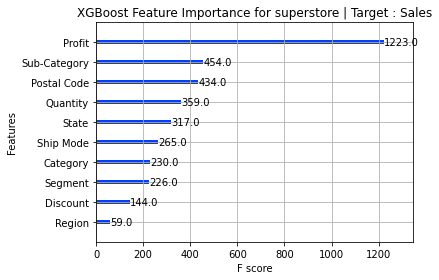

Target Variable: Sub-Category
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Category', 'Quantity', 'Discount', 'City_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 62%|██████▏   | 26/42 [00:00<00:00, 127.81it/s]

GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lasso model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoLa

100%|██████████| 42/42 [00:00<00:00, 124.20it/s]


TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:37:35] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7fbbc83b59c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7fbbc83c2eb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7fbbc83c3d10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xa4) [0x7fbbc8306754]
  [bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7fbc3f3d4a4a]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x5fea

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

XGBoost failed
Target Variable: Category
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Region', 'Quantity', 'Discount', 'City_na', 'Sub-Category_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 64%|██████▍   | 27/42 [00:00<00:00, 127.26it/s]

GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lasso model failed to execute
Input contains NaN, infinity or a value too large for dtype('f

100%|██████████| 42/42 [00:00<00:00, 123.51it/s]


SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:37:36] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7fbbc83b59c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7fbbc83c2eb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7fbbc83c3d10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xa4) [0x7fbbc8306754]
  [bt] (4) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model
XGBoost failed
Target Variable: Region


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Quantity', 'Discount', 'City_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 62%|██████▏   | 26/42 [00:00<00:00, 126.86it/s]

GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lasso model failed to execute
Input contains NaN, infinity or a value too large for dtype('f

100%|██████████| 42/42 [00:00<00:00, 121.69it/s]


SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:37:37] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7fbbc83b59c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7fbbc83c2eb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7fbbc83c3d10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrix

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model
XGBoost failed


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Target Variable: Postal Code
CATS=====================
['Ship Mode', 'Segment', 'Country', 'State', 'Quantity', 'Discount']
CONTS=====================
['City', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'State', 'Quantity', 'Discount', 'City_na', 'Region_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3997


  5%|▍         | 2/42 [00:00<00:04,  8.65it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6995720872446585, 'Adjusted R-Squared': 0.6934252245795876, 'RMSE': 17195.64804763854, 'Time taken': 0.10234737396240234}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9963764335427827, 'Adjusted R-Squared': 0.9963022940756274, 'RMSE': 1888.4979718556801, 'Time taken': 0.12332749366760254}
{'Model': 'BayesianRidge', 'R-Squared': 0.11101020051294186, 'Adjusted R-Squared': 0.09282115090706866, 'RMSE': 29579.906456012, 'Time taken': 0.04707002639770508}


 10%|▉         | 4/42 [00:00<00:03, 10.94it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9952685645929088, 'Adjusted R-Squared': 0.9951717577303596, 'RMSE': 2157.9673280852926, 'Time taken': 0.10532879829406738}
{'Model': 'DummyRegressor', 'R-Squared': -0.0021352494438480196, 'Adjusted R-Squared': -0.02263929546827459, 'RMSE': 31405.924084441114, 'Time taken': 0.01798701286315918}
{'Model': 'ElasticNet', 'R-Squared': 0.09532841514542467, 'Adjusted R-Squared': 0.07681851059597056, 'RMSE': 29839.66080977849, 'Time taken': 0.028690576553344727}


 17%|█▋        | 7/42 [00:00<00:03, 10.54it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.016537249776934493, 'Adjusted R-Squared': -0.0035847502276293852, 'RMSE': 31111.95950981303, 'Time taken': 0.24314498901367188}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9976964591388338, 'Adjusted R-Squared': 0.9976493278680171, 'RMSE': 1505.7274489430768, 'Time taken': 0.0789182186126709}


 21%|██▏       | 9/42 [00:01<00:06,  5.13it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.998040567556512, 'Adjusted R-Squared': 0.9980004768671312, 'RMSE': 1388.7163691549924, 'Time taken': 0.6717302799224854}
{'Model': 'GammaRegressor', 'R-Squared': 0.07800175741071691, 'Adjusted R-Squared': 0.05913734324009223, 'RMSE': 30124.056534184987, 'Time taken': 0.02557659149169922}


 26%|██▌       | 11/42 [00:03<00:13,  2.29it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -76189.93272794153, 'Adjusted R-Squared': -77748.82649219608, 'RMSE': 8659644.279744783, 'Time taken': 1.8013181686401367}


 29%|██▊       | 12/42 [00:03<00:13,  2.31it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9850235190602338, 'Adjusted R-Squared': 0.9847170948977834, 'RMSE': 3839.311028516913, 'Time taken': 0.41678476333618164}


 36%|███▌      | 15/42 [00:04<00:08,  3.27it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9793590203494186, 'Adjusted R-Squared': 0.9789366985151355, 'RMSE': 4507.269851627744, 'Time taken': 0.5238301753997803}
{'Model': 'HuberRegressor', 'R-Squared': 0.10700845859166686, 'Adjusted R-Squared': 0.08873753191323552, 'RMSE': 29646.4079166164, 'Time taken': 0.04983115196228027}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.48681917867684354, 'Adjusted R-Squared': 0.4763193153249632, 'RMSE': 22474.167642540873, 'Time taken': 0.08211898803710938}


 43%|████▎     | 18/42 [00:05<00:06,  3.89it/s]

{'Model': 'KernelRidge', 'R-Squared': -2.7550050040414793, 'Adjusted R-Squared': -2.831833750927238, 'RMSE': 60793.012880162074, 'Time taken': 0.6520845890045166}
{'Model': 'Lars', 'R-Squared': 0.11117116701774299, 'Adjusted R-Squared': 0.0929854108441931, 'RMSE': 29577.228365831164, 'Time taken': 0.032897233963012695}
{'Model': 'LarsCV', 'R-Squared': 0.11117116701774299, 'Adjusted R-Squared': 0.0929854108441931, 'RMSE': 29577.228365831164, 'Time taken': 0.06672477722167969}
{'Model': 'Lasso', 'R-Squared': 0.11117486822391609, 'Adjusted R-Squared': 0.09298918777836973, 'RMSE': 29577.166783932542, 'Time taken': 0.031599998474121094}


 55%|█████▍    | 23/42 [00:05<00:02,  7.28it/s]

{'Model': 'LassoCV', 'R-Squared': 0.11120563463484245, 'Adjusted R-Squared': 0.09302058368107968, 'RMSE': 29576.654877197678, 'Time taken': 0.20391583442687988}
{'Model': 'LassoLars', 'R-Squared': 0.11136090999791148, 'Adjusted R-Squared': 0.0931790360336745, 'RMSE': 29574.071193837754, 'Time taken': 0.02896404266357422}
{'Model': 'LassoLarsCV', 'R-Squared': 0.11117116701774299, 'Adjusted R-Squared': 0.0929854108441931, 'RMSE': 29577.228365831164, 'Time taken': 0.05495953559875488}
{'Model': 'LassoLarsIC', 'R-Squared': 0.11171983550230424, 'Adjusted R-Squared': 0.09354530528240257, 'RMSE': 29568.098037464722, 'Time taken': 0.035424232482910156}
{'Model': 'LinearRegression', 'R-Squared': 0.11117116701774299, 'Adjusted R-Squared': 0.0929854108441931, 'RMSE': 29577.228365831164, 'Time taken': 0.026467084884643555}
{'Model': 'LinearSVR', 'R-Squared': -2.5743267982006794, 'Adjusted R-Squared': -2.647458804301972, 'RMSE': 59312.405245295115, 'Time taken': 0.028629064559936523}


 62%|██████▏   | 26/42 [00:11<00:14,  1.14it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.6030842383072983, 'Adjusted R-Squared': -2.676804631929954, 'RMSE': 59550.52783434539, 'Time taken': 6.206820011138916}


 71%|███████▏  | 30/42 [00:12<00:06,  1.87it/s]

{'Model': 'NuSVR', 'R-Squared': -0.005269048656981523, 'Adjusted R-Squared': -0.025837213335385245, 'RMSE': 31454.990833455275, 'Time taken': 0.6325597763061523}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.10128583093575083, 'Adjusted R-Squared': 0.08289781724645684, 'RMSE': 29741.248914264437, 'Time taken': 0.020707130432128906}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.11224143004679343, 'Adjusted R-Squared': 0.09407757183803223, 'RMSE': 29559.415628510415, 'Time taken': 0.04761075973510742}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.003658597964596333, 'Adjusted R-Squared': -0.01672690386732989, 'RMSE': 31315.005769182455, 'Time taken': 0.11955475807189941}
{'Model': 'PoissonRegressor', 'R-Squared': 0.12927257929122282, 'Adjusted R-Squared': 0.11145718449411235, 'RMSE': 29274.502146630366, 'Time taken': 0.04068493843078613}


 76%|███████▌  | 32/42 [08:20<11:12, 67.28s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0026635719595464735, 'Adjusted R-Squared': -0.023178427651813216, 'RMSE': 31414.201545259395, 'Time taken': 487.9599323272705}


 79%|███████▊  | 33/42 [08:20<08:26, 56.31s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -0.3216201830554821, 'Adjusted R-Squared': -0.34866100521518506, 'RMSE': 36066.31226437071, 'Time taken': 0.24191832542419434}


 81%|████████  | 34/42 [08:21<06:06, 45.84s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9967679760792367, 'Adjusted R-Squared': 0.9967018477125715, 'RMSE': 1783.5516497137103, 'Time taken': 1.0853679180145264}
{'Model': 'Ridge', 'R-Squared': 0.1111690264162376, 'Adjusted R-Squared': 0.0929832264452144, 'RMSE': 29577.263981812048, 'Time taken': 0.016848325729370117}
{'Model': 'RidgeCV', 'R-Squared': 0.11114863995000768, 'Adjusted R-Squared': 0.09296242286458589, 'RMSE': 29577.603175907323, 'Time taken': 0.043794870376586914}
{'Model': 'SGDRegressor', 'R-Squared': 0.11145067951925769, 'Adjusted R-Squared': 0.09327064227157, 'RMSE': 29572.57738307913, 'Time taken': 0.037633657455444336}


 90%|█████████ | 38/42 [08:22<01:28, 22.13s/it]

{'Model': 'SVR', 'R-Squared': -0.0005976660639868125, 'Adjusted R-Squared': -0.021070252581919968, 'RMSE': 31381.82166723779, 'Time taken': 0.8596065044403076}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.11117116701774299, 'Adjusted R-Squared': 0.0929854108441931, 'RMSE': 29577.228365831164, 'Time taken': 0.023879528045654297}
{'Model': 'TweedieRegressor', 'R-Squared': 0.07846493844003999, 'Adjusted R-Squared': 0.05961000111912018, 'RMSE': 30116.488925227124, 'Time taken': 0.03350186347961426}


100%|██████████| 42/42 [08:23<00:00, 12.00s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9983154085304788, 'Adjusted R-Squared': 0.9982809411858339, 'RMSE': 1287.6436958576533, 'Time taken': 0.782813549041748}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9800252192591479, 'Adjusted R-Squared': 0.9796165280930946, 'RMSE': 4433.935975635846, 'Time taken': 0.17460966110229492}
Project: superstore
superstore
Target: Postal Code
Postal Code
Target Standard Deviation: 31975.457176718475
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
XGBRegressor                                 1.00       1.00    1287.64   
ExtraTreesRegressor                          1.00       1.00    1388.72   
ExtraTreeRegressor                           1.00       1.00    1505.73   
RandomForestRegressor                        1.00       1.00    1783.55   
BaggingRegressor                             1.00       1.00    1888.50   
DecisionTreeRegressor                   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost Predictions vs Actual==========
   actual  predicted
0   19901   20767.81
1   53711   53311.03
2   14609    9998.32
3   98103   98423.48
4   48127   48553.89
XGBoost RMSE:  1286.7738732225168


<Figure size 432x288 with 0 Axes>

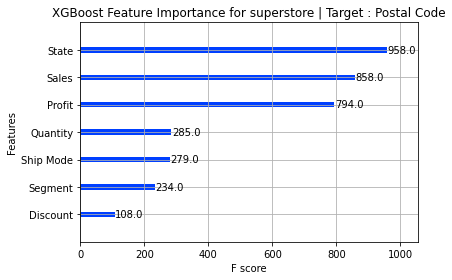

Target Variable: State
CATS=====================
['Ship Mode', 'Segment', 'Country', 'Quantity', 'Discount']
CONTS=====================
['City', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'Quantity', 'Discount', 'City_na', 'Region_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 52%|█████▏    | 22/42 [00:00<00:00, 107.90it/s]

ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GammaRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a 

100%|██████████| 42/42 [00:00<00:00, 110.96it/s]


PoissonRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
QuantileRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Tweed

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: City
CATS=====================
['Ship Mode', 'Segment', 'Country', 'Quantity', 'Discount']
CONTS=====================
['State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Country', 'Quantity', 'Discount', 'State_na', 'Region_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 55%|█████▍    | 23/42 [00:00<00:00, 113.47it/s]

ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GammaRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infini

100%|██████████| 42/42 [00:00<00:00, 112.36it/s]


QuantileRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRe

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: Country
CATS=====================
['Ship Mode', 'Segment', 'Quantity', 'Discount']
CONTS=====================
['City', 'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['City', 'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Segment', 'Quantity', 'Discount', 'City_na', 'State_na', 'Region_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3997


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 60%|█████▉    | 25/42 [00:00<00:00, 120.74it/s]

ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GammaRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value 

100%|██████████| 42/42 [00:00<00:00, 116.68it/s]


RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:46:06] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

Could not fit model
XGBoost failed
Target Variable: Segment
CATS=====================
['Ship Mode', 'Quantity', 'Discount']
CONTS=====================
['Country', 'City', 'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
12
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Country', 'City', 'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales', 'Profit']
Categorical variables that made the cut : ['Ship Mode', 'Quantity', 'Discount', 'Country_na', 'City_na', 'State_na', 'Region_na', 'Category_na', 'Sub-Category_na']
Tabular Object size: 3993


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').


 57%|█████▋    | 24/42 [00:00<00:00, 116.93it/s]

ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GammaRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GaussianProcessRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
GradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HistGradientBoostingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
HuberRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KNeighborsRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
KernelRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lars model failed to execute
Input contains NaN, infinity or a value 

100%|██████████| 42/42 [00:00<00:00, 116.45it/s]


RANSACRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RandomForestRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Ridge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
RidgeCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[20:46:07] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infin

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model
XGBoost failed


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

<Figure size 432x288 with 0 Axes>

In [21]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

     feature  importance
0  Ship Mode      327.00
1    Segment      192.00
2      State      256.00
3     Region       74.00
4   Category      172.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

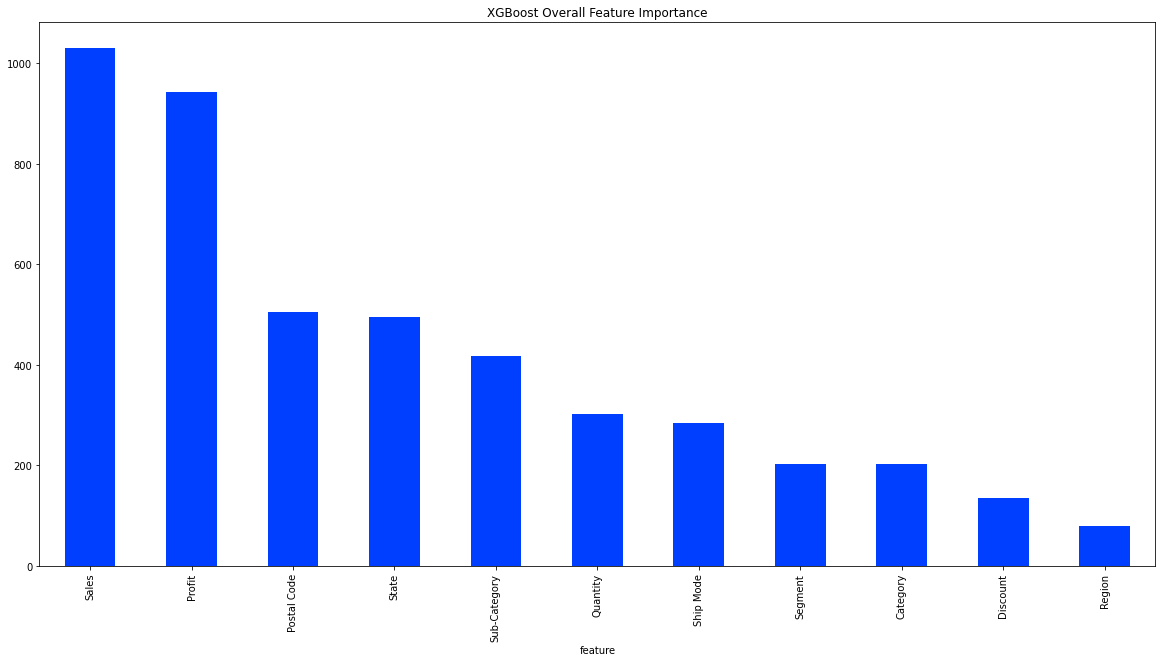

In [22]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [23]:
df.isna().sum()

Ship Mode          0
Segment         3993
Country         3993
City            3993
State           3993
Postal Code        0
Region          3993
Category        3993
Sub-Category    3993
Sales              0
Quantity           0
Discount           0
Profit             0
dtype: int64

# **To Be Continued...**